In [2]:
from IPython.display import display, HTML
from io import BytesIO
import cv2
import numpy as np
from PIL import Image
import requests

import matplotlib.pyplot as plt

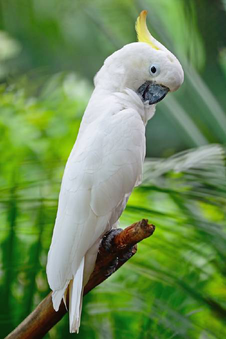

In [3]:
url = 'https://www.camdenadvertiser.com.au/images/transform/v1/crop/frm/storypad-6zTxM8dqZST83uhbZgFjq3/6c0bb10a-97ba-4f62-8f21-76be4596165b.jpg/r0_0_577_866_w1200_h678_fmax.jpg'
response = requests.get(url)
test_img = Image.open(BytesIO(response.content))
h, w = test_img.size
test_img = test_img.resize((h // 2, w // 2), Image.LANCZOS)
display(test_img)

In [4]:
def create_curve(low_y, high_y):
    t = np.linspace(0.0, 1.0, 256)

    # Defines responze of a four-point bezier curve
    def evaluate_bez(t):
        return 3 * (1 - t) ** 2 * t * low_y + 3 * (1 - t) * t ** 2 * high_y + t ** 3

    evaluate_bez = np.vectorize(evaluate_bez)
    remapping = np.rint(evaluate_bez(t) * 255).astype(np.uint8)
    return remapping

In [5]:
def explore_curve_distribution(scale, image, k=200):
    array_image = np.array(image)
    fig, ax = plt.subplots()
    X = np.arange(256)
    
    darkest_curve = None
    darkest_curve_deviation = np.inf
    
    brightest_curve = None
    brightest_curve_deviation = -np.inf
    
    for _ in range(k):
        low_y = np.clip(np.random.normal(loc=0.25, scale=scale), 0, 1)
        high_y = np.clip(np.random.normal(loc=0.75, scale=scale), 0, 1)
        
        curve = create_curve(low_y, high_y)
        curve_diff = curve - X
        summed_curve_diff = np.sum(curve_diff)

        if summed_curve_diff < darkest_curve_deviation:
            darkest_curve = np.copy(curve)
            darkest_curve_deviation = summed_curve_diff
        if summed_curve_diff > brightest_curve_deviation:
            brightest_curve = np.copy(curve)
            brightest_curve_deviation = summed_curve_diff

        plt.plot(X, curve)
    
    plt.title(f'All curves from {k} sampled (low_shift, high_shift) parameters')
    plt.show()
        
    display(HTML(f'<h4>Image with darkest curve at scale {scale}</h4>'))
    display(Image.fromarray(cv2.LUT(array_image, darkest_curve)))
    
    display(HTML(f'<h4>Image with brightest curve at scale {scale}</h4>'))
    display(Image.fromarray(cv2.LUT(array_image, brightest_curve)))
    

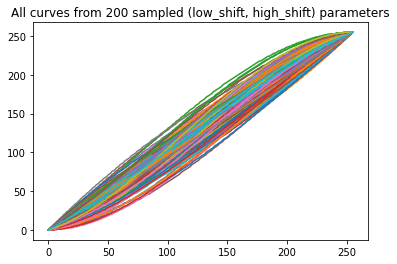

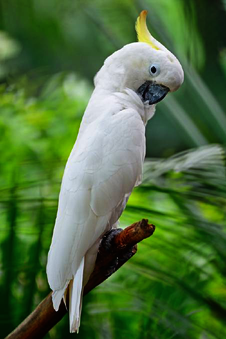

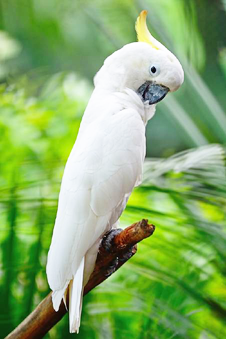

In [6]:
explore_curve_distribution(scale=0.1, image=test_img)

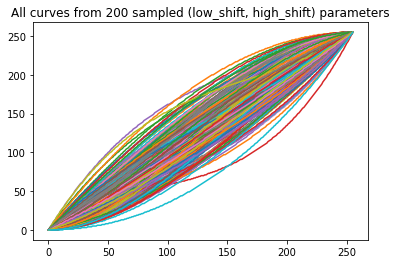

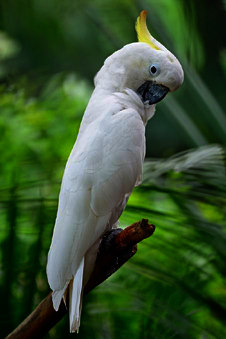

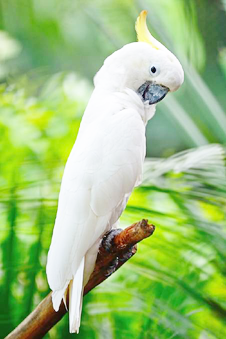

In [7]:
explore_curve_distribution(scale=0.2, image=test_img)

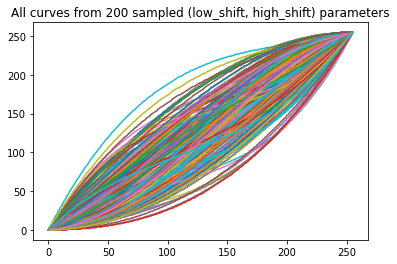

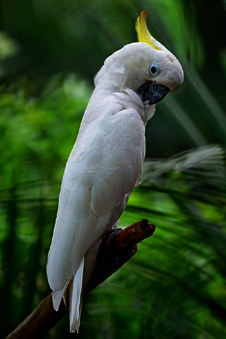

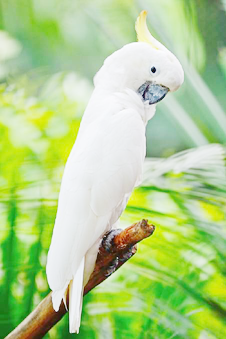

In [8]:
explore_curve_distribution(scale=0.3, image=test_img)

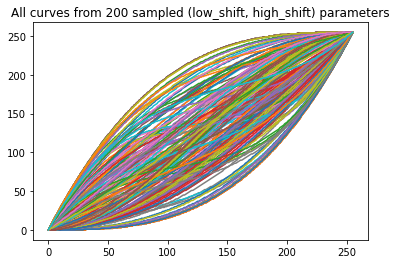

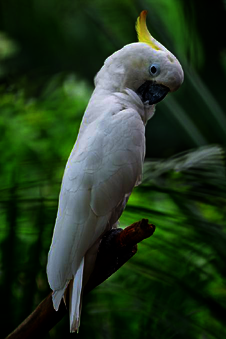

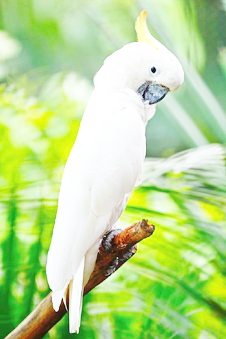

In [9]:
explore_curve_distribution(scale=0.5, image=test_img)

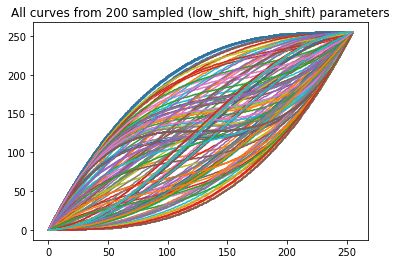

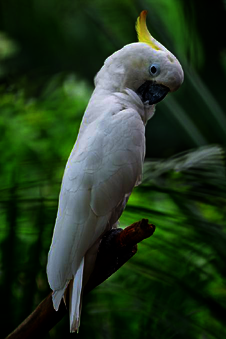

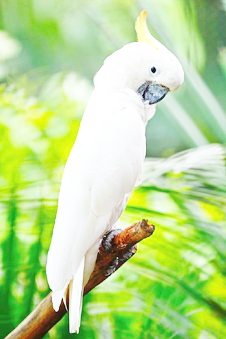

In [10]:
explore_curve_distribution(scale=1.0, image=test_img)

# Test of applying tone curve adjustment by channel

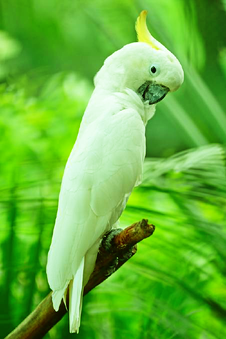

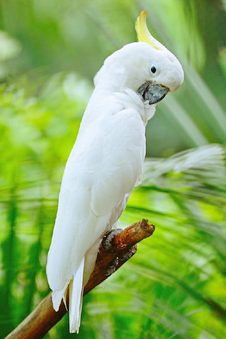

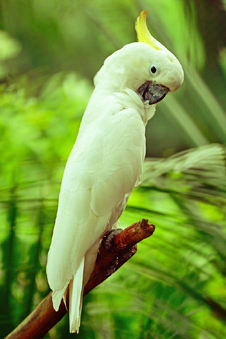

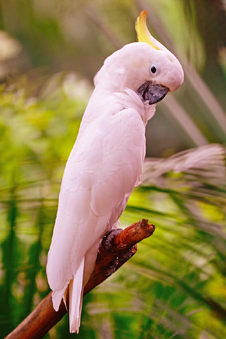

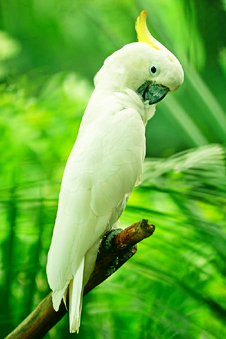

In [64]:
scale=0.2
for _ in range(5):
    array_image = np.array(test_img)
    for channel_i in range(3):
        low_y = np.clip(np.random.normal(loc=0.25, scale=scale), 0, 1)
        high_y = np.clip(np.random.normal(loc=0.75, scale=scale), 0, 1)
        array_image[:,:,channel_i] = cv2.LUT(array_image[:,:,channel_i], create_curve(low_y, high_y))
    display(Image.fromarray(array_image))